# DQN Implementation


在第5章讲解的 Q-learning算法中，我们以矩阵的方式建立了一张存储每个状态下所有动作的Q值的表格。

然而，这种用表格存储动作价值的做法只在环境的状态和动作都是离散的，
并且空间都比较小的情况下适用，
我们之前进行代码实战的几个环境都是如此（如悬崖漫步）。

当状态或者动作数量非常大的时候，这种做法就不适用了。例如，当状态是一张RGB 图像时，
假设图像大小是$210 \times 160 \times 3$ ，此时一共有 $256^{210 \times 160 \times 3}$
种状态，在计算机中存储这个数量级的Q值表格是不现实的。

更甚者，当状态或者动作连续的时候，就有无限个状态动作对，我们更加无法
使用这种表格形式来记录各个状态动作对的Q值。


## 车杆环境

<img src="./media/cartpole.gif">

在车杆环境中，有一辆小车，智能体的任务是通过左右移动保持车上的杆竖直，
若杆的倾斜度数过大，或者车子离初始位置左右的偏离程度过大，或者坚持时间到达200 帧，则游戏结束。
智能体的状态是一个维数为 4 的向量，每一维都是连续的，其动作是离散的，动作空间大小为2，详情参见下表。
在游戏中每坚持一帧，智能体能获得分数为1 的奖励，坚持时间越长，则最后的分数越高，坚持 200 帧即可获得最高的分数。

| 维度 | 状态         | 最小值     | 最大值     |
|------|--------------|------------|------------|
| 0    | 车的位置     | -2.4       | 2.4        |
| 1    | 车的速度     | -Inf       | Inf        |
| 2    | 杆的角度     | ～-41.8°   | ～41.8°    |
| 3    | 杆尖端的速度 | -Inf       | Inf        |

## DQN

现在我们想在类似车杆的环境中得到动作价值函数**Q(s, a)**,
由于状态每一维度的值都是连续的，无法使用表格记录，因此一个常见的解决方法便是:使
用函数拟合（function approximation）的思想。

由于神经网络具有强大的表达能力，因此我们可以用一个神经网络来表示函数**Q**。

若动作是连续（无限）的，神经网络的输入是状态s和动作a，然后输出一个标量，表示在状态s下采取动作a 能获得的价值。

若动作是离散（有限）的，除了可以采取动作连续情况下的做法，我们还可以只将状态s输入到神经网络中，使其同时输出每一个动作的Q值。

通常 DQN（以及 Q-learning）只能处理动作离散的情况，因为在函数**Q**的更新过程中有$max_a$这一操作。

假设神经网络用来拟合函数$Q$的参数是$\omega$，即每一个状态$s$下所有可能动作$a$的$Q$值都能表示为$Q_{\omega}(s,a)$。

我们将用于拟合函数Q的神经网络称为Q网络

<img src="./media/Qnet.png" style="zoom:60%;">

Q Learning update rule:

$Q(S,a) = Q(s,a)+\alpha[r+\gamma max_{a^{'} \in A} Q(s^{'},a^{'})-Q(s,a)]$

上述公式用时序差分（temporal difference，TD）学习目标TD target,来增量式更新 Q(s, a)，
也就是说要使 Q(s, a)向 TD target 靠近。

于是，对于一组数据，我们可以很自然地将Q 网络的损失函数构造为均方误差的形式.

$\omega^* = argmin_\omega \frac{1}{2N} \Sigma_{i=1}^{N}[Q_\omega(s_i,a_i)-(r_i+\gamma max_{a^{'} \in A} Q_\omega (s_i^{'},a^{'}))]$

### 经验回放

在一般的有监督学习中，假设训练数据是独立同分布的，我们每次训练神经网络的时候从
训练数据中随机采样一个或若干个数据来进行梯度下降，随着学习的不断进行，每一个训练数
据会被使用多次。在原来的 Q-learning算法中，每一个数据只会用来更新一次Q 值。为了更好
地将 Q-learning和深度神经网络结合，DQN 算法采用了经验回放（experience replay）方法，
具体做法为维护一个回放缓冲区，将每次从环境中采样得到的四元组数据（状态、动作、奖励、下一状态）
存储到回放缓冲区中，训练 Q 网络的时候再从回放缓冲区中随机采样若干数据来进行训练。

### 目标网络

DQN 便使用了目标网络（ target network）的思想：
既然在训练过程中 Q 网络的不断更新会导致目标不断发生改变，不如暂时先将TD 误差目标中的 Q 网络固定住。

<img src="./media/pseudocode.png" style="zoom:60%;">

In [2]:
import random
import gymnasium as gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return np.array(states), actions, rewards, np.array(next_states), dones

    def size(self):
        return len(self.buffer)


In [4]:
class QNetwork(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, taget_update,device):
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.device = device

        self.q_network = QNetwork(state_dim, hidden_dim, action_dim).to(self.device)
        self.target_q_network = QNetwork(state_dim, hidden_dim, action_dim).to(self.device)
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.taget_update = taget_update
        self.learn_step_counter = 0 # 记录学习次数，用于更新目标网络

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            q_values = self.q_network(state)
            action = torch.argmax(q_values).item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 计算当前 Q 网络的 Q 值
        q_values = self.q_network(states).gather(1, actions)

        # 计算目标 Q 值
        with torch.no_grad():
            max_next_q_values = self.target_q_network(next_states).max(dim=1, keepdim=True)[0]
            target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)

        # 计算损失函数
        loss = F.mse_loss(q_values, target_q_values)

        # 优化当前 Q 网络
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 定期更新目标网络
        self.learn_step_counter += 1
        if self.learn_step_counter % self.taget_update == 0:
            self.target_q_network.load_state_dict(self.q_network.state_dict())

In [11]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
# 环境种子（新版 Gym 推荐用 reset(seed=...)）
env.reset(seed=0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated  # 回合结束：要么终止（如杆倒），要么截断（如步数超限）
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当 buffer 数据的数量超过一定值后,才进行 Q 网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix(
                    {
                        'episode': '%d' % (num_episodes/10 * i + i_episode+1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    }
                )
            pbar.update(1)

Iteration 9: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s, episode=500, return=332.500]


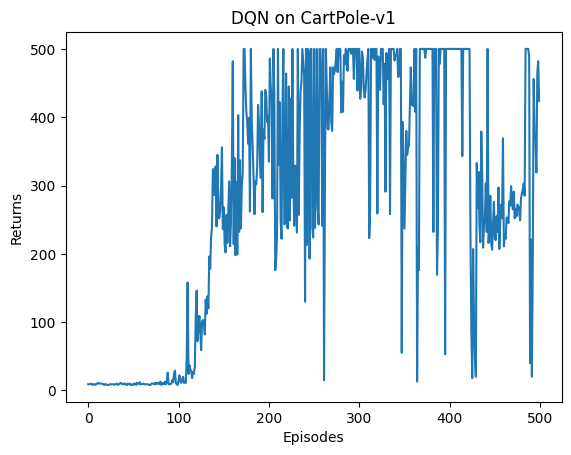

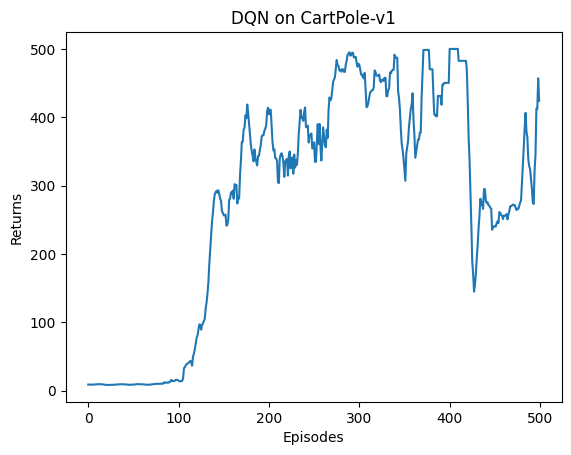

In [12]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list,return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()